In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기 (파일 경로에 맞게 수정 필요)
df = pd.read_csv("/Users/sangrimkoo/Desktop/프로젝트/사용하는데이터/VIP데이터.csv")

In [2]:
len(df)

11460

In [3]:
df = df.sort_values(by=['발급회원번호', '기준년월'])

In [4]:
def calc_slope_6m(series):
    # 데이터가 2개 미만이거나 전부 0이면 계산 불가 (0 반환)
    if len(series) < 2 or np.sum(series) == 0:
        return 0
    
    y = series.values
    x = np.arange(len(y))
    
    # 값이 6개월 내내 똑같으면 기울기 0
    if np.all(y == y[0]): return 0
    
    # 선형 회귀로 기울기 계산
    slope, _, _, _, _ = linregress(x, y)
    
    # 계산 오류(NaN)가 나면 0으로 처리
    if np.isnan(slope): return 0
    
    return slope

In [5]:
print("고객별 추세(기울기) 계산 중... (시간이 좀 걸릴 수 있어!)")

# 각 지표별로 6개월 기울기 계산
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)

# 잔액 컬럼 이름 확인 필요 (보통 '잔액_합계_B0M' 또는 '잔액_B0M')
balance_col = '잔액_B0M' if '잔액_B0M' in df.columns else df.columns[df.columns.str.contains('잔액')][0]
df['Slope_Balance'] = df.groupby('발급회원번호')[balance_col].transform(calc_slope_6m)

df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# 가장 최근 월(12월) 데이터만 추출 (현재 시점 기준 분석)
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

print(f"분석 대상 월: {target_month}")

고객별 추세(기울기) 계산 중... (시간이 좀 걸릴 수 있어!)
분석 대상 월: 201812


In [6]:
scaler = MinMaxScaler()

def convert_slope_to_score(df_in, col_name):
    # 감소(음수)하는 경우만 추출하여 양수로 변환 (감소폭이 클수록 높은 점수)
    # 증가하거나 변동 없는 경우(0 이상)는 0점으로 처리 (위험하지 않으니까!)
    negative_slopes = df_in[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 0~1 사이로 점수 압축 (MinMax Scaling)
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 점수 계산
score_spend = convert_slope_to_score(df_final, 'Slope_Spend')
score_balance = convert_slope_to_score(df_final, 'Slope_Balance')
score_count = convert_slope_to_score(df_final, 'Slope_Count')

In [7]:
# 가중치 설정 (합계 100)
W_SPEND = 40   # 소비 감소 비중 (제일 중요!)
W_BALANCE = 30 # 잔액 감소 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 리스크 비중

# 리스크 점수 (연체나 거절 이력 있으면 1, 없으면 0)
has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) | 
    (df_final.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# 최종 점수 계산
df_final['Churn_Score'] = (
    (score_spend * W_SPEND) + 
    (score_balance * W_BALANCE) + 
    (score_count * W_COUNT) + 
    (has_risk * W_RISK)
)

# 보기 좋게 소수점 첫째 자리까지만 남김
df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

In [8]:
print(f"\n[Churn_Score 생성 완료]")
print(f"전체 고객 수: {len(df_final)}명")
print(f"점수 평균: {df_final['Churn_Score'].mean():.2f}점")
print(f"점수 최대값: {df_final['Churn_Score'].max()}점")

print("\n[상위 5명 데이터 확인]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head())


[Churn_Score 생성 완료]
전체 고객 수: 1910명
점수 평균: 8.97점
점수 최대값: 63.7점

[상위 5명 데이터 확인]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
10325  SYN_3968 -243906.428571 -117226.657143         63.7
10596  SYN_5296 -206826.314286 -381888.542857         55.4
11267  SYN_9037 -229686.857143 -119831.371429         54.9
10230  SYN_3442 -168908.285714 -186469.485714         51.4
9864   SYN_1527 -186951.657143 -241112.200000         49.6


In [9]:
#### 모델을 만들고 shap를 한다

In [10]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# 학습에 방해되는 컬럼(정답 만들 때 쓴 재료들 + ID) 제거
drop_cols = ['Churn_Score', 'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
             '발급회원번호', '기준년월', 'VIP등급코드', 'Target', 'Churn_Refined']

# 실제 데이터에 있는 것만 골라서 뺌
existing_drop_cols = [c for c in drop_cols if c in df_final.columns]

# X: 문제 (숫자 데이터만), y: 정답 (점수)
X = df_final.drop(columns=existing_drop_cols).select_dtypes(include=[np.number])
X = X.fillna(0) # 빈칸은 0으로 채움
y = df_final['Churn_Score']

print("데이터 준비 완료!")

/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


데이터 준비 완료!


In [11]:
# 회귀 모델(XGBoost Regressor) 생성
# n_estimators=100: 공부를 100번 반복해라
model = xgb.XGBRegressor(n_estimators=100, random_state=42)

print("모델 학습 중...")
model.fit(X, y)
print("학습 완료! AI가 이제 점수를 예측할 수 있어.")

모델 학습 중...
학습 완료! AI가 이제 점수를 예측할 수 있어.


In [12]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

print("\n[Top 20 Features and their Importance Scores]")
print("="*50)
for idx in sorted_idx[::-1][:20]:
    print(f"{X.columns[idx]}: {feature_importance[idx]:.4f}")

print("\n[Churn Score Statistics]")
print("="*50)
print(df_final['Churn_Score'].describe())


[Top 20 Features and their Importance Scores]
이용건수_할부_R6M: 0.1065
이용금액_할부_R3M: 0.0696
평잔_RV일시불_해외_6M: 0.0455
이용금액_할부_R6M: 0.0333
정상청구원금_B5M: 0.0211
잔액_카드론_B4M: 0.0192
포인트_마일리지_건별_B0M: 0.0191
카드론이용월수_누적: 0.0167
평잔_RV일시불_해외_3M: 0.0154
이용금액_할부_B0M: 0.0152
이용금액_부분무이자_R12M: 0.0146
할부금액_유이자_3M_R12M: 0.0120
이용금액_신용_B0M: 0.0118
여유_Pet이용금액: 0.0109
이용개월수_할부_유이자_R6M: 0.0106
평잔_카드론_3M: 0.0104
RV_최대잔액_R12M: 0.0102
이용건수_선결제_R6M: 0.0090
평잔_6M: 0.0090
이용메뉴건수_ARS_R6M: 0.0088

[Churn Score Statistics]
count    1910.000000
mean        8.968901
std         9.084385
min         0.000000
25%         1.900000
50%         6.300000
75%        13.375000
max        63.700000
Name: Churn_Score, dtype: float64


In [13]:
# -------------------------------------------------------
# 8. 결과 파일 저장하기 (CSV)
# -------------------------------------------------------

# (1) 고객별 이탈 점수 및 등급표 저장
df_final.to_csv("VIP_고객_이탈위험점수.csv", index=False, encoding='utf-8-sig')

# (2) 변수 중요도(Feature Importance) 저장
# 보기 좋게 표(DataFrame)로 만들어서 저장할게
importance_df = pd.DataFrame({
    '변수명': X.columns,
    '중요도': feature_importance
})

# 중요도가 높은 순서대로 정렬하기
importance_df = importance_df.sort_values(by='중요도', ascending=False)

# 파일로 저장
importance_df.to_csv("이탈예측_변수중요도.csv", index=False, encoding='utf-8-sig')

print("\n🎉 파일 저장이 완료되었어!")
print("📂 1. VIP_고객_이탈위험점수.csv (고객별 점수표)")
print("📂 2. 이탈예측_변수중요도.csv (중요한 변수 순위)")


🎉 파일 저장이 완료되었어!
📂 1. VIP_고객_이탈위험점수.csv (고객별 점수표)
📂 2. 이탈예측_변수중요도.csv (중요한 변수 순위)


In [14]:
df = pd.read_csv("이탈예측_변수중요도.csv")

In [15]:
df.head()

,변수명,중요도
0,이용건수_할부_R6M,0.106484
1,이용금액_할부_R3M,0.069555
2,평잔_RV일시불_해외_6M,0.045521
3,이용금액_할부_R6M,0.033338
4,정상청구원금_B5M,0.021147


In [16]:
len(df)

858

In [17]:
sum(df['중요도'] == 0)

409

In [18]:
df[df['중요도'] == 0]

,변수명,중요도
449,잔액_현금서비스_B2M,0.0
450,증감_RP건수_전월,0.0
451,RP후경과월_유선방송,0.0
452,연체잔액_CA_B0M,0.0
453,당사PAY_방문월수_R6M,0.0
...,...,...
853,연체잔액_대환론_B0M,0.0
854,컨택건수_CA_당사앱_B0M,0.0
855,연체잔액_카드론_B0M,0.0
856,컨택건수_리볼빙_LMS_B0M,0.0


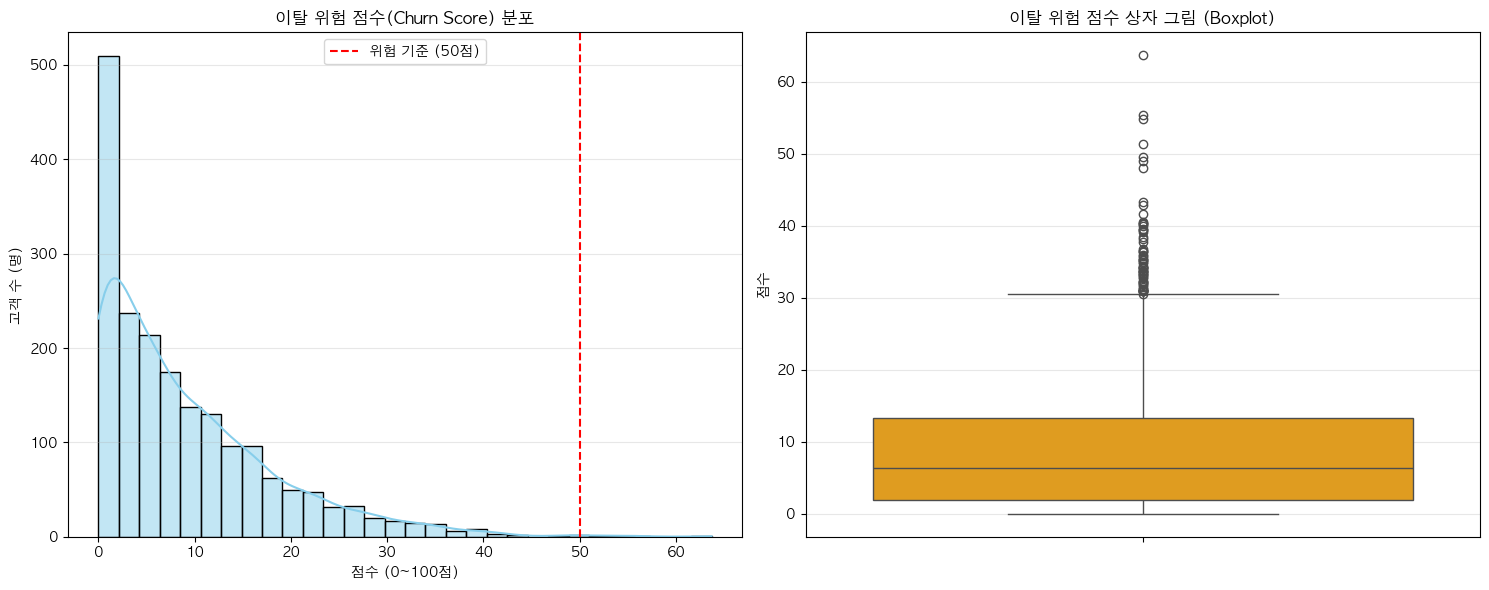

평균 점수: 8.97점
중앙값: 6.30점
최고 점수: 63.7점


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# -------------------------------------------------------
# 1. 한글 폰트 설정 (깨짐 방지)
# -------------------------------------------------------
# Windows는 'Malgun Gothic', Mac은 'AppleGothic' 사용
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False

# -------------------------------------------------------
# 2. 그래프 그리기
# -------------------------------------------------------
plt.figure(figsize=(15, 6))

# (1) 히스토그램 (전체적인 모양 보기)
plt.subplot(1, 2, 1)
sns.histplot(df_final['Churn_Score'], bins=30, kde=True, color='skyblue')
plt.title('이탈 위험 점수(Churn Score) 분포')
plt.xlabel('점수 (0~100점)')
plt.ylabel('고객 수 (명)')
plt.grid(axis='y', alpha=0.3)

# 기준선 표시 (예: 50점)
plt.axvline(50, color='red', linestyle='--', label='위험 기준 (50점)')
plt.legend()

# (2) 상자 그림 (이상치 및 쏠림 확인)
plt.subplot(1, 2, 2)
sns.boxplot(y=df_final['Churn_Score'], color='orange')
plt.title('이탈 위험 점수 상자 그림 (Boxplot)')
plt.ylabel('점수')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 3. 통계 수치로도 확인하기
# -------------------------------------------------------
print(f"평균 점수: {df_final['Churn_Score'].mean():.2f}점")
print(f"중앙값: {df_final['Churn_Score'].median():.2f}점")
print(f"최고 점수: {df_final['Churn_Score'].max()}점")

In [20]:
!pip3 install pandas numpy statsmodels

  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 29.4 MB/s  0:00:00eta 0:00:01
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 1. 파일 불러오기
# (1) 중요도 파일: 어떤 변수를 살릴지 결정
importance_df = pd.read_csv("이탈예측_변수중요도.csv")

In [23]:

# (2) 실제 데이터 파일: VIF 계산용 숫자 데이터 (X값)
data_df = pd.read_csv("VIP_고객_이탈위험점수.csv")

In [24]:
# 2. 분석 대상 변수 추려내기
# 중요도가 0보다 큰 변수 이름만 리스트로 뽑기
valid_features = importance_df[importance_df['중요도'] > 0]['변수명'].tolist()

# 실제 데이터(data_df)에서 해당 변수들만 뽑아서 X 만들기
X = data_df[valid_features].copy()

# 혹시 빈칸(NaN)이 있으면 계산 에러가 나니까 0으로 채우기
X = X.fillna(0)

# 데이터가 잘 만들어졌는지 확인
print(f"분석할 변수 개수: {len(X.columns)}개")
print("데이터 예시:")
print(X.head(3))

분석할 변수 개수: 449개
데이터 예시:
   이용건수_할부_R6M  이용금액_할부_R3M  평잔_RV일시불_해외_6M  이용금액_할부_R6M  정상청구원금_B5M  \
0            1            0               0            0     1444044   
1            0            0               0            0      649543   
2            1            0               0       441459      232923   

   잔액_카드론_B4M  포인트_마일리지_건별_B0M  카드론이용월수_누적  평잔_RV일시불_해외_3M  이용금액_할부_B0M  ...  \
0           0                0           0               0            0  ...   
1           0             1000           0               0            0  ...   
2           0                0           3               0            0  ...   

   월중평잔_할부  이용금액_B페이_R3M  컨택건수_이용유도_TM_B0M  이용횟수_선결제_R6M  방문후경과월_앱_R6M  \
0    47804             0                 0             0             6   
1        0             0                 0             0             6   
2    90976             0                 0             0             6   

   이용개월수_체크_R12M  최대이용금액_체크_R12M  수신거부여부_메일  이용개월수_일시불_R12M  컨택건수_카드론

In [25]:
# VIF 기준값 설정 (보통 10이 넘으면 위험)
vif_threshold = 10

print("=== VIF 최적화 시작 (하나씩 제거) ===")

while True:
    # 1. 상수항 추가 (VIF 계산 필수 요건)
    # (add_constant는 계산용으로만 쓰고 나중에 버림)
    X_with_const = add_constant(X)
    
    # 2. VIF 계산
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                       for i in range(X_with_const.shape[1])]
    
    # 'const'는 계산용이니 제외하고 변수만 확인
    vif_data = vif_data[vif_data['feature'] != 'const']
    
    # 3. 가장 VIF가 높은 변수 찾기
    max_vif = vif_data['VIF'].max()
    max_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
    
    # 4. 기준(10)을 넘는지 심사
    if max_vif > vif_threshold:
        print(f"🚫 제거됨: {max_feature} (VIF: {max_vif:.2f})")
        # 해당 변수를 X에서 영구 삭제 후 다시 반복
        X = X.drop(columns=[max_feature])
    else:
        # 5. 모두 기준 통과 시 종료
        print(f"\n✅ 최적화 완료! (모든 변수 VIF <= {vif_threshold})")
        print("-" * 50)
        # 결과 예쁘게 출력 (VIF 높은 순)
        print(vif_data.sort_values(by='VIF', ascending=False).head(10))
        break

# 최종 변수 목록 저장
final_features = list(X.columns)
print(f"\n🎉 최종 남은 변수: {len(final_features)}개")
pd.DataFrame(final_features, columns=['최종선택변수']).to_csv("VIF_최적화_완료_변수.csv", index=False)

=== VIF 최적화 시작 (하나씩 제거) ===


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용건수_할부_R6M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_할부_R3M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_할부_R6M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 정상청구원금_B5M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_할부_B0M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_부분무이자_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 할부금액_유이자_3M_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_신용_B0M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_신용_R6M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용건수_할부_무이자_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 유효카드수_신용체크 (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_신용_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 할부금액_유이자_12M_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용건수_할부_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용건수_일시불_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 할부건수_무이자_3M_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용카드수_신용 (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 선입금원금_B2M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 할부금액_6M_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용건수_신용_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 할부금액_3M_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 잔액_할부_무이자_B0M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용건수_일시불_R6M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용가능카드수_신용 (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거됨: 이용금액_일시불_R12M (VIF: inf)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_신판_R3M (VIF: 1439589.85)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: RV신청일자 (VIF: 868961.24)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_신판_R6M (VIF: 319385.14)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_신용_B0M (VIF: 180402.87)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_교통 (VIF: 174277.85)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_신용_R3M (VIF: 80160.04)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_일시불_B0M (VIF: 43546.42)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_일시불_R6M (VIF: 3021.83)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_신판_R3M (VIF: 2755.25)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_일시불_R3M (VIF: 2069.17)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_일시불_R3M (VIF: 1939.98)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_할부_R12M (VIF: 1218.56)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_일시불_B0M (VIF: 1190.43)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 쇼핑_온라인_이용금액 (VIF: 1182.99)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_간편결제_R3M (VIF: 1052.97)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용건수_오프라인_R3M (VIF: 1000.08)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_페이_오프라인_R6M (VIF: 894.04)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 이용금액_체크_R3M (VIF: 871.63)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 포인트_마일리지_건별_R3M (VIF: 862.57)


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


🚫 제거됨: 입회경과개월수_신용 (VIF: 850.70)
🚫 제거됨: 잔액_신판ca최대한도소진율_r3m (VIF: 783.94)
🚫 제거됨: 이용금액_할부_무이자_R12M (VIF: 772.34)
🚫 제거됨: 잔액_B0M (VIF: 765.16)
🚫 제거됨: 이용금액_A페이_R3M (VIF: 726.31)
🚫 제거됨: 최초카드론이용경과월 (VIF: 638.05)
🚫 제거됨: 이용금액_R3M_신용 (VIF: 590.53)
🚫 제거됨: 잔액_신판평균한도소진율_r3m (VIF: 515.70)
🚫 제거됨: 이용금액_페이_온라인_R3M (VIF: 504.91)
🚫 제거됨: 이용건수_신판_B0M (VIF: 469.71)
🚫 제거됨: 이용금액_신용_R3M (VIF: 444.29)
🚫 제거됨: 이용건수_체크_B0M (VIF: 386.19)
🚫 제거됨: 이용건수_온라인_R3M (VIF: 364.46)
🚫 제거됨: 잔액_신판ca평균한도소진율_r3m (VIF: 352.12)
🚫 제거됨: 월중평잔_할부_B0M (VIF: 350.15)
🚫 제거됨: 월중평잔_RV일시불 (VIF: 345.38)
🚫 제거됨: 이용금액_페이_오프라인_R3M (VIF: 343.64)
🚫 제거됨: 이용금액_쇼핑 (VIF: 342.26)
🚫 제거됨: 이용금액_온라인_R3M (VIF: 337.13)
🚫 제거됨: 이용금액_여유생활 (VIF: 321.46)
🚫 제거됨: 정상청구원금_B2M (VIF: 319.42)
🚫 제거됨: 잔액_카드론_B4M (VIF: 306.14)
🚫 제거됨: 교통_주유이용금액 (VIF: 288.15)
🚫 제거됨: 잔액_신판ca최대한도소진율_r6m (VIF: 285.21)
🚫 제거됨: 캠페인접촉건수_R12M (VIF: 280.74)
🚫 제거됨: 이용건수_오프라인_R6M (VIF: 277.16)
🚫 제거됨: 이용가능카드수_체크 (VIF: 276.33)
🚫 제거됨: 이용금액_신판_R6M (VIF: 224.10)
🚫 제거됨: 이용금액_오프라인_R3M (VIF: 218.00)
🚫 제거됨: 마일_적립포인

In [31]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 주의: 위에서 3시간 동안 돌려서 만들어진 'X'가 메모리에 있어야 합니다!

print("⏳ 결과 정리 중... (반복 없어서 금방 끝납니다!)")

# 1. 최적화된 X에 상수항 추가 (계산용)
X_final_const = add_constant(X)

# 2. 남은 변수들에 대해 VIF 값 한 번만 싹 계산
final_vif_df = pd.DataFrame()
final_vif_df["변수명"] = X_final_const.columns
final_vif_df["VIF"] = [variance_inflation_factor(X_final_const.values, i) 
                       for i in range(X_final_const.shape[1])]

# 3. 불필요한 상수항(const) 제거
final_vif_df = final_vif_df[final_vif_df['변수명'] != 'const']

# 4. VIF 점수가 높은 순서대로 정렬 (내림차순)
final_vif_df = final_vif_df.sort_values(by='VIF', ascending=False)

# 5. 화면에 출력
print("\n✅ 최종 VIF 점수 정렬 결과:")
print(final_vif_df)

# 6. CSV 파일로 예쁘게 저장
final_vif_df.to_csv("VIF_최적화_최종점수_정렬.csv", index=False, encoding='utf-8-sig')
print("\n🎉 'VIF_최적화_최종점수_정렬.csv' 파일로 저장 완료!")

⏳ 결과 정리 중... (반복 없어서 금방 끝납니다!)

✅ 최종 VIF 점수 정렬 결과:
                   변수명       VIF
182  컨택건수_이용유도_청구서_B0M  9.749834
198           연체건수_R6M  9.748268
88      증감율_이용건수_신용_분기  9.735530
44     증감율_이용건수_일시불_분기  9.671022
81          연체입금원금_B2M  9.593935
..                 ...       ...
192        카드론잔액_최종경과월  1.190877
41              최종연체회차  1.185832
204      증감_RP건수_통신_전월  1.170175
181     증감율_이용금액_CA_전월  1.164532
25       증감_RP건수_교통_전월  1.160859

[228 rows x 2 columns]

🎉 'VIF_최적화_최종점수_정렬.csv' 파일로 저장 완료!


In [33]:
import pandas as pd

# -----------------------------------------------------------
# 1. VIF 생존자 + 중요도 상위 146개 뽑기 (이건 똑같아!)
# -----------------------------------------------------------
# X 컬럼(VIF 통과한 애들) 목록
vif_survivors = list(X.columns)

# 중요도 파일 불러와서 교집합 찾기
importance_df = pd.read_csv("이탈예측_변수중요도.csv")
survivor_importance = importance_df[importance_df['변수명'].isin(vif_survivors)]
survivor_importance = survivor_importance.sort_values(by='중요도', ascending=False)

# 최종 146개 변수명 확정
top_146_features = survivor_importance.head(146)['변수명'].tolist()
print(f"최종 선발 변수: {len(top_146_features)}개")


# -----------------------------------------------------------
# 2. 전체 데이터 로딩 없이, 가지고 있는 데이터로 합치기
# -----------------------------------------------------------
# df_final: 맨 처음에 회원번호랑 같이 있던 그 데이터프레임 (아직 메모리에 있지?)
# 여기서 '발급회원번호'랑 '최종 146개 변수'만 쏙 뽑으면 돼!

# 필요한 컬럼만 선택 (회원번호 + 146개)
final_cols = ['발급회원번호'] + top_146_features
df_final_X = df_final[final_cols].copy()

# 정답(Churn_Score) 붙이기 (이건 점수 파일에서 가져오거나 df_final에서 가져오면 돼)
df_score = pd.read_csv("VIP_고객_이탈위험점수.csv")
df_score_slim = df_score[['발급회원번호', 'Churn_Score']]

# 최종 합체!
df_final_dataset = pd.merge(df_final_X, df_score_slim, on='발급회원번호', how='inner')

# 저장
df_final_dataset.to_csv("VIP_학습용데이터_Top146_VIF완료.csv", index=False, encoding='utf-8-sig')
print("\n💾 'VIP_학습용데이터_Top146_VIF완료.csv' 저장 완료!")

최종 선발 변수: 146개

💾 'VIP_학습용데이터_Top146_VIF완료.csv' 저장 완료!


In [36]:
import pandas as pd

# 1. 방금 만든 '146개 변수 데이터' 불러오기
# (여기에는 '발급회원번호', 'Churn_Score', '146개 변수'가 이미 들어있어!)
df_146 = pd.read_csv("VIP_학습용데이터_Top146_VIF완료.csv")

# 2. 원본 데이터에서 '기준년월', 'VIP등급코드'만 쏙 빼오기
# (전체를 다 불러오면 느리니까 usecols로 필요한 것만 가져오자)
df_info = pd.read_csv("/Users/sangrimkoo/Desktop/프로젝트/사용하는데이터/VIP데이터.csv", 
                      usecols=['발급회원번호', '기준년월', 'VIP등급코드'])

# 3. 하나로 합치기 (회원번호 기준)
df_final = pd.merge(df_146, df_info, on='발급회원번호', how='left')

# 4. 보기 좋게 컬럼 순서 정리 (기본정보 4개 맨 앞으로)
# [회원번호, 기준년월, 등급, 점수] + [나머지 변수들...]
base_cols = ['발급회원번호', '기준년월', 'VIP등급코드', 'Churn_Score']
feature_cols = [c for c in df_final.columns if c not in base_cols]

df_final = df_final[base_cols + feature_cols]

print(f"🎉 최종 데이터셋 완성!")
print(f"총 컬럼 개수: {len(df_final.columns)}개 (예상: 150개)")
print(f"행 개수: {len(df_final)}명")

# 5. 저장
df_final.to_csv("VIP_최종학습데이터_150컬럼.csv", index=False, encoding='utf-8-sig')
print("📂 'VIP_최종학습데이터_150컬럼.csv' 저장 끝!")

🎉 최종 데이터셋 완성!
총 컬럼 개수: 150개 (예상: 150개)
행 개수: 11460명
📂 'VIP_최종학습데이터_150컬럼.csv' 저장 끝!


In [40]:
import pandas as pd
import os

# =============================================================================
# 1. 파일 경로 설정 (상림아, 여기 경로는 꼭 확인해서 맞춰줘!)
# =============================================================================
# (1) 우리가 방금 만든 최종 150개 컬럼 데이터
target_data_path = "VIP_최종학습데이터_150컬럼.csv" 

# (2) 원본 14개 시트가 들어있는 엑셀 파일 경로
# 만약 엑셀 하나에 시트가 다 들어있다면 이 경로를 쓰면 돼.
# (csv로 따로따로 있다면 아래에서 코드를 조금 바꿔야 해!)
original_excel_path = "/Users/sangrimkoo/Desktop/프로젝트/사용하는데이터/Final_merged_all_data.csv"  # <-- 여기 수정 필요!

# =============================================================================
# 2. 150개 핵심 컬럼 명단 확보
# =============================================================================
try:
    df_150 = pd.read_csv(target_data_path)
    target_columns = df_150.columns.tolist()
    print(f"✅ 분석 대상 컬럼: {len(target_columns)}개 로드 완료!")
except FileNotFoundError:
    print("❌ 'VIP_최종학습데이터_150컬럼.csv' 파일을 찾을 수 없어. 경로를 확인해줘!")
    target_columns = []

# =============================================================================
# 3. 원본 시트 뒤져서 위치 찾기 (탐정 모드 발동!)
# =============================================================================
result_list = []

# 엑셀 파일 열기 (시간이 좀 걸릴 수 있어!)
if target_columns:
    print(f"📂 원본 파일({original_excel_path})을 열고 있어... 잠시만 기다려줘!")
    try:
        # 모든 시트의 이름 가져오기
        xl = pd.ExcelFile(original_excel_path)
        sheet_names = xl.sheet_names
        print(f"📋 발견된 시트 목록: {sheet_names}")

        # 시트 하나씩 돌면서 컬럼 찾기
        for sheet in sheet_names:
            print(f"  🔍 '{sheet}' 시트 검색 중...")
            # 헤더만 살짝 읽어서 컬럼명만 가져오기 (데이터 다 읽으면 느리니까!)
            df_sheet = pd.read_excel(original_excel_path, sheet_name=sheet, nrows=0)
            sheet_cols = df_sheet.columns.tolist()
            
            # 우리 150개 리스트랑 비교!
            for target_col in target_columns:
                if target_col in sheet_cols:
                    # 찾았다!
                    col_index = sheet_cols.index(target_col) + 1 # 0부터 시작하니까 1 더해주기
                    result_list.append({
                        '변수명': target_col,
                        '원본_시트명': sheet,
                        '원본_순서(번째)': col_index
                    })
                    
    except Exception as e:
        print(f"❌ 원본 엑셀 파일을 읽는 중 오류 발생: {e}")
        print("csv 파일들이 따로따로 있는 경우라면 코드를 수정해야 해!")

# =============================================================================
# 4. 결과 정리 및 저장
# =============================================================================
if result_list:
    result_df = pd.DataFrame(result_list)
    
    # 150개 리스트 순서대로 보기 좋게 정렬 (찾은 것만)
    # 못 찾은 건(파생변수 등) 맨 뒤로 가거나 빠질 수 있어.
    
    print("\n" + "="*50)
    print("🎉 [추적 결과] 150개 컬럼 위치 확인 완료!")
    print("="*50)
    print(result_df.head(10)) # 상위 10개만 미리보기
    
    # 엑셀이나 CSV로 저장해서 상림이가 보기 편하게!
    result_df.to_csv("VIP_150개컬럼_원본위치정리.csv", index=False, encoding='utf-8-sig')
    print("\n📂 'VIP_150개컬럼_원본위치정리.csv' 파일로 저장했어! 열어봐!")
    
    # 혹시 원본에 없던 변수(우리가 새로 만든 파생변수)가 있는지 확인
    found_cols = result_df['변수명'].tolist()
    missing_cols = [c for c in target_columns if c not in found_cols]
    
    if missing_cols:
        print(f"\n⚠️ 원본 시트에서 못 찾은 변수(새로 만든 변수 등): {len(missing_cols)}개")
        print(f"예시: {missing_cols[:5]} ...")
else:
    print("\n❌ 결과를 찾지 못했어. 경로를 다시 한 번 확인해줘!")

✅ 분석 대상 컬럼: 150개 로드 완료!
📂 원본 파일(/Users/sangrimkoo/Desktop/프로젝트/사용하는데이터/Final_merged_all_data.csv)을 열고 있어... 잠시만 기다려줘!
❌ 원본 엑셀 파일을 읽는 중 오류 발생: Excel file format cannot be determined, you must specify an engine manually.
csv 파일들이 따로따로 있는 경우라면 코드를 수정해야 해!

❌ 결과를 찾지 못했어. 경로를 다시 한 번 확인해줘!
